## **Finding a maximum independent set using a quantum computer with neutral atoms**

### **Quantum adiabatic algorithm**

The first step is to create a register with a given geometrical graph. For doing this, we will use the `__init__` function of the `Quantum_MIS` class that takes a graph and map it on the register.

Let's build a graph with 6 nodes first using networkx.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

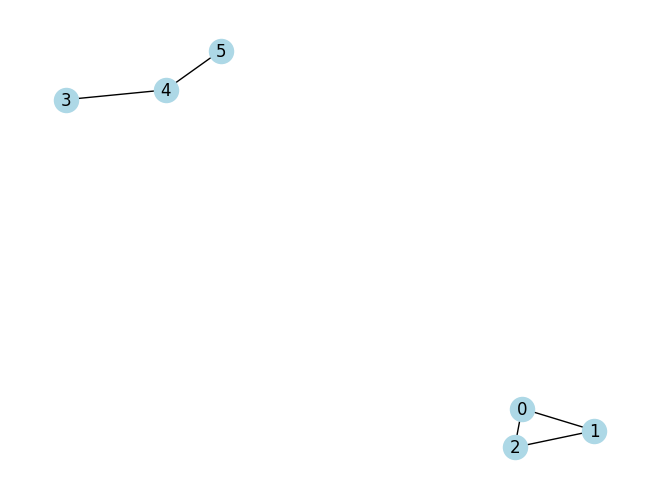

In [ ]:
#creating a graph with determined edges

G = nx.Graph()
edges = np.array([(0, 1), (0, 2), (1,2), (3, 4), (4, 5)]) #be careful, the nodes must be noted from 0 to n where n is the number of total nodes
G.add_edges_from(edges)

#setting the position of the nodes using spring_layout
pos = nx.spring_layout(G, seed = 42)#the seed can be changed, but the seed 42 is used by the Quantum_MIS class

#plot the graph
nx.draw(G, pos = pos, with_labels = True, node_color="lightblue")
plt.show()

We now use the Quantum_MIS class with the graph and a pulser device. The object is created to then run the algorithm with the run method later. Like it is done earlier, the graph given must be a **networkx.Graph** object.

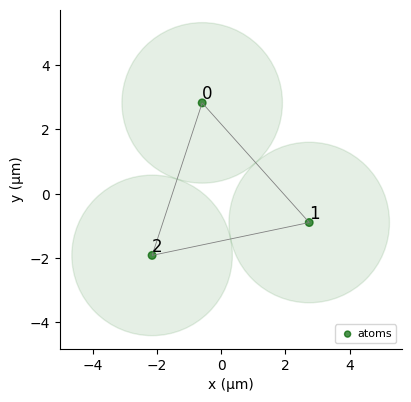

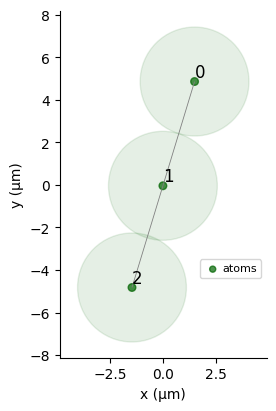

In [3]:
#creating the quantum solver object
from QMIS_code.QAA import Quantum_MIS
from pulser.devices import AnalogDevice

#We first want to specify the device used to run the quantum_MIS algorithm 
device = AnalogDevice

#we only need to pass the graph object in the Quantum_MIS class
mis_solution = Quantum_MIS(G, device)

#the Quantum_MIS class creates a register for each connected components
# we can now print the registers created
mis_solution.print_regs() 


Now that we have created the register, we need to create a Pulse. In this project, 5 types of pulse have been implemented in the `pulse_utils` file. 
- "Rise_sweep_fall" -> A pulse that starts to 0, rises during a quarter of the total time to the omega specified, stays constant during half of the total time, and falls to 0 during a quarter of the total time.

- "Pyramid" -> A pulse that starts at a certain value that is Omega - delta. The pulse stays at this value for a quarter of the total time, does a Rise_Fall pulse for half of the total time, and finally stays constant at Omega-delta for the last quarter of the total time.

- "Blackman" -> This pulse is a normal form with a total area of Omega with a length given by the time.

- "Rise_fall" -> This pulse is only the rise and fall part of the Rise_Sweep_Fall pulse. It rises during half of the time from 0 to Omega and falls back to 0 for the last half of the total time.

- "Waveform" -> This pulse starts at 0, is at Omega at half of the total time, and falls back to 0 at the end, but follows a waveform pattern instead of a linear pattern like the Rise_Fall. 

With those options, it is possible to create a pulse object with the `pulse_constructor` that takes the time of the pulse in nanoseconds and the pulse type in a string. There is also other optional parameters that can be used.
- T_pyramid (float=0): The time for the rise_fall part in the middle in µs, only for the 'Pyramid' pulse.

- delta (float=0) : The difference between Omega and the constant parts of the pulse.

- delta_0 (float=-5): The initial decoherence value in rad/µs.

- delta_f (float=5): The final decoherence value in rad/µs.

In [4]:
from QMIS_code.pulse_utils import Pulse_constructor

T = 4000 #time of the pulse in ns, the time limit is 4000.

pulse_type = "Rise_fall" #the pulse type used.

#constructing the pulse using the time and the pulse_type
pulse = Pulse_constructor(T, pulse_type)






It's now time to run the quantum_MIS algorithm with the run method of the Quantum_MIS object. This algorithm takes a graph with all its connected components, resolves each connected components with a quantum adiabatic algorithm, and combines them to return a count dictionary.

The mandatory parameter is the pulse. The progress_bar boolean prints or not the progress of the calculation of the pulse application on the register. The number of shots is also specified. By default it is set to 1000. Finally, if an histogram of the results need to be generated, the generate_histogram parameter must be set to True. If no file name (file_name) is given, the histogram is just shown. Otherwise, it will be saved under that file name in the ReQpex directory. 

In [5]:
shots = 100 #the number of shots doesn't have to be this big for the results to be good

counts_results = mis_solution.run(pulse, progress_bar=False, shots = shots)
print(counts_results)

{'000001': 6, '000010': 12, '000100': 6, '000101': 92, '001001': 41, '001010': 47, '001100': 41, '001101': 127, '010001': 29, '010010': 35, '010100': 29, '010101': 115, '100001': 32, '100010': 38, '100100': 32, '100101': 118}


There's an argument in the run method named `generate_histogram`. Here's an example of the histogram it would produces by using the `plot_histogram` in the `QMIS_code/QMIS_utils.py` file. The function takes the counts dictionary returned form the run method, the number of shots. Also the file_name argument as the the same role as the one described in the previous paragraph.

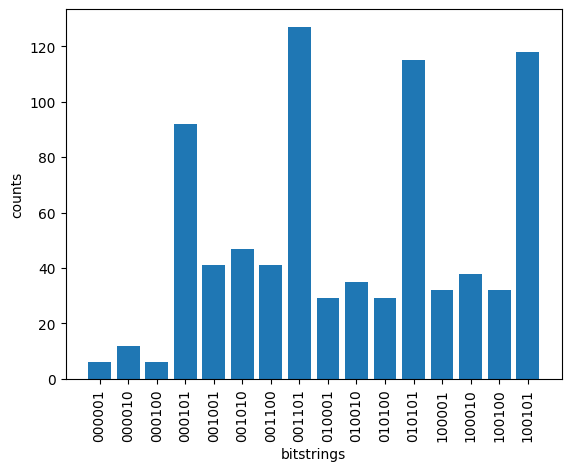

In [6]:
from QMIS_code.QMIS_utils import plot_histogram

plot_histogram(counts_results, shots) #you can also give a file_name in argument in this function to save the histogram in your repository

We can now obtain the maximum independent set of the graph by extracting the maximal bitstring and find the related nodes: 

In [7]:

best_bitstring = max(zip(counts_results.values(),counts_results.keys()))[1]
print("best bitstring in the histogram: ", best_bitstring)

independent_nodes = []
for j in range(len(best_bitstring)):
    if best_bitstring[j] == "1":
        independent_nodes.append(j)

print("nodes contained in the maximal independent set: ", independent_nodes)

best bitstring in the histogram:  001101
nodes contained in the maximal independent set:  [2, 3, 5]


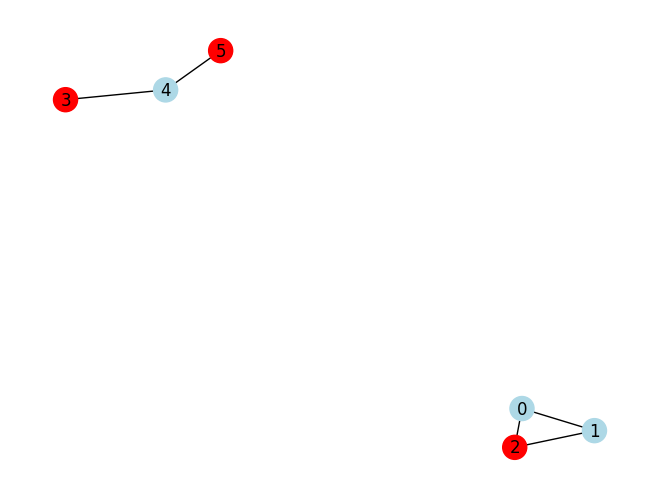

In [8]:
#the red nodes are part of the maximal independent set and the blue nodes are not part of the maximal independent set
node_colors = ["red" if node in independent_nodes else "lightblue" for node in G.nodes]

nx.draw(G, pos = pos, with_labels = True, node_color = node_colors)
plt.show()

### **Quantum approximate optimization algorithm**

For this algorithm, we will use a different graph. The register will be created by the init function of the class Quantum_QAOA. 

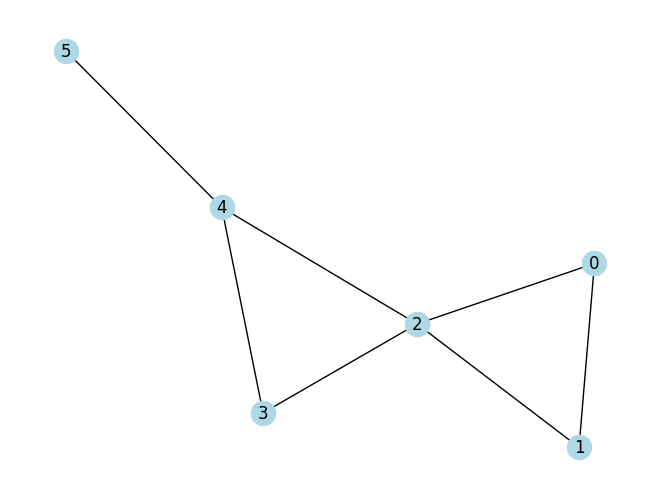

In [9]:
#new graph tested
qaoa_graph = nx.Graph()
edges = [(0, 1), (0, 2), (1, 2), (2, 3), (2, 4), (3, 4), (4, 5)]
qaoa_graph.add_edges_from(edges)

#setting the position of the nodes using spring_layout
pos = nx.spring_layout(qaoa_graph, seed = 42)#the seed can be changed, but the seed 42 is used by the Quantum_QAOA class

#plot the graph
nx.draw(qaoa_graph, pos = pos, with_labels = True, node_color="lightblue")
plt.show()

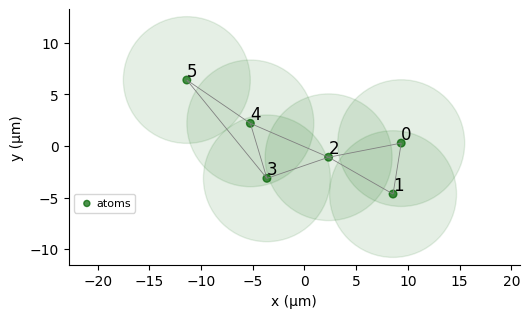

In [10]:
from QMIS_code.QAOA import Quantum_QAOA

qaoa_solver = Quantum_QAOA(qaoa_graph)
#use this line to print the register created with the graph given. 
qaoa_solver.print_reg()

Note that the register created can comport more edges between the atoms than it should. In example, the edge between the nodes 3 and 5 should not be there, but the register created determine an interaction between these two atoms.

We can now run the QAOA algorithm to find the maximal independent set. We first need to define an optimization function that returns the optimal parameters that minimize a cost function. A wrapper just like the one in the cell below is created.

In [11]:
from scipy.optimize import minimize
from typing import Callable
from numpy.typing import NDArray
#this function is simply a callable for the run function of the QAOA
def minimizer(cost_function : Callable, params: NDArray[np.float_], method : str = 'COBYLA'):
    return minimize(cost_function, params, method = 'COBYLA').x

Then the run method can be called to run the QAOA algorithm on the graph. It need the number of shots and the minimizer function. An histogram can also be created if the optional parameter `generate_histogram` is set to True. The figure will be saved into the ReQpex directory into the file_name argument file name.

In [12]:
#the return of this algorithm is a count dictionary
qaoa_results = qaoa_solver.run(shots = shots, minimizer = minimizer, pulse_type = "Rise_fall")

print(qaoa_results)

Counter({'010101': 197, '100101': 161, '010001': 142, '000100': 116, '010010': 74, '000010': 53, '100100': 40, '100000': 38, '000000': 32, '100010': 31, '001001': 28, '010100': 28, '010000': 23, '001000': 22, '000101': 11, '100001': 4})


The histogram can now be shown with the plot histogram function used in the previous QAA method section.

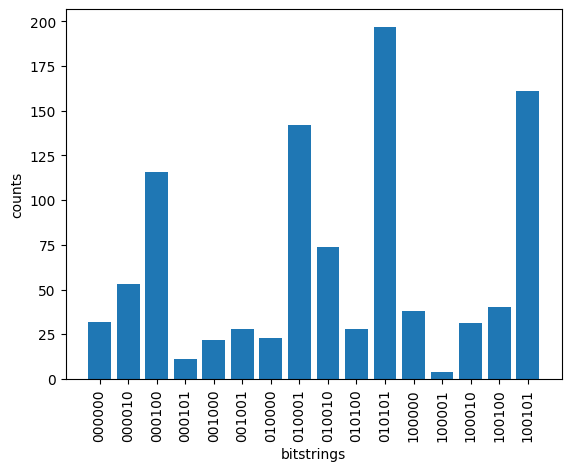

In [13]:
#we can obtain the histogram using the same function as earlier
plot_histogram(qaoa_results, shots)

Using the same logic as with the QAA, we can extract the best bitstring to find the MIS returned. We can also observe that even if the maximal result is an MIS for this graph, the other solutions given are not maximal independent sets. For our implementation, we find that the QAOA gives less amount of good answers than the QAA. That's why we use the QAA for the Big_QMIS presented after this. 

In [14]:
best_bitstring = max(zip(qaoa_results.values(),qaoa_results.keys()))[1]
print("best bitstring in the histogram: ", best_bitstring)

independent_nodes = []
for j in range(len(best_bitstring)):
    if best_bitstring[j] == "1":
        independent_nodes.append(j)

print("nodes contained in the maximal independent set: ", independent_nodes)

best bitstring in the histogram:  010101
nodes contained in the maximal independent set:  [1, 3, 5]


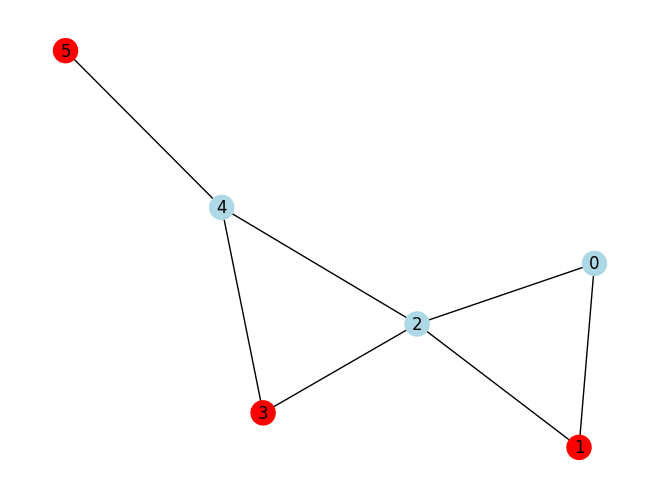

In [15]:
#the red nodes are part of the maximal independent set and the blue nodes are not part of the maximal independent set
node_colors = ["red" if node in independent_nodes else "lightblue" for node in G.nodes]

nx.draw(qaoa_graph, pos = pos, with_labels = True, node_color = node_colors)
plt.show()

## **Big graph maximal independent set**
We have learned to find the maximal independent set of a graph using a neural atom quantum computer, but this method uses an emulator that doesn't work with a lot of nodes (10 nodes is a lot for this method). We need to use a function for bigger graph using the quantum_MIS for sub graphs. We will then combine them to find the MIS of the total graph.  

First, let's construct a bigger graph that isn't too much confusing.

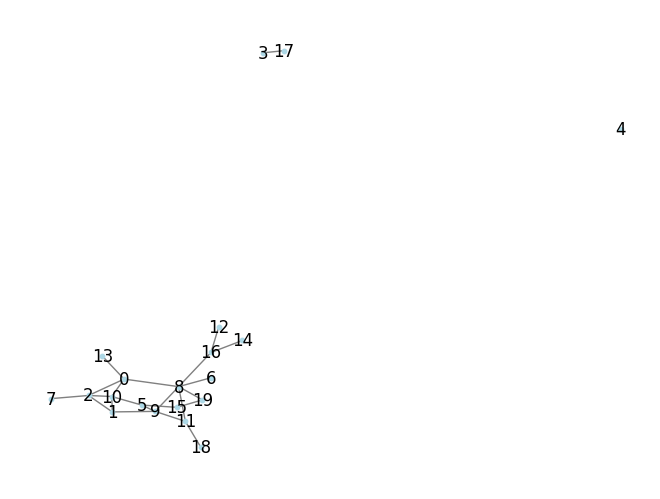

In [16]:
n_nodes = 20
p_edge = 0.1  # small probability for the graph to not be too dense
big_graph = nx.erdos_renyi_graph(n=n_nodes, p=p_edge, seed=42)

pos_2 = nx.spring_layout(big_graph, k=0.1, seed=42)



nx.draw(
    big_graph,
    with_labels=True,
    node_color="lightblue",
    node_size=10, #small nodes to see the edges
    edge_color="gray",
    pos=pos_2,
)
plt.show()

If we put this bigger graph in a register, the register obtained will not be optimal. It will creates new edges between the nodes and the solution obtained will be different. A new register creation method should be imagined to gain better performance.

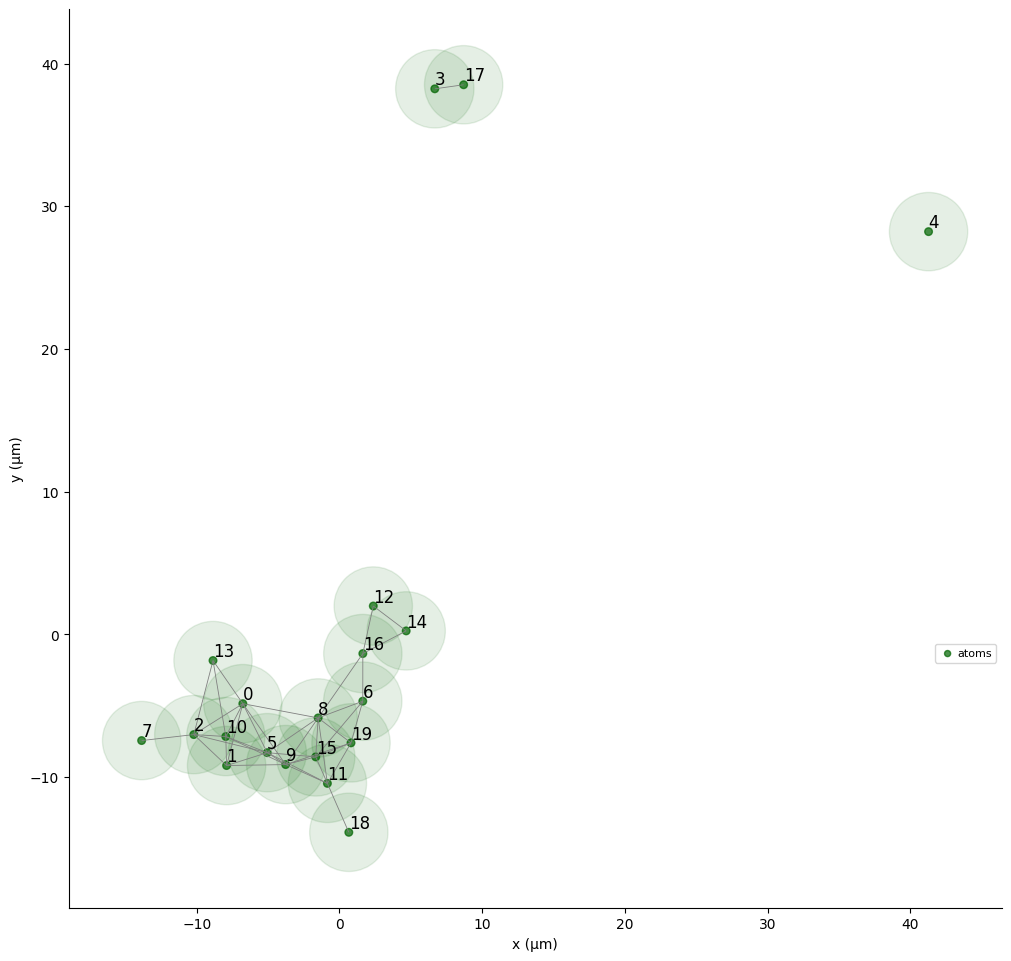

In [17]:
#we use the find_minimal_radius and scale_coordinates functions to create a register
from QMIS_code.QMIS_utils import find_minimal_radius, scale_coordinates
from scipy.spatial.distance import pdist
from pulser.devices import DigitalAnalogDevice
from pulser import Register



R_blockade = find_minimal_radius(big_graph, pos_2)
coord = np.array(list(pos_2.values()))


min_dist = DigitalAnalogDevice.min_atom_distance
max_dist = DigitalAnalogDevice.max_radial_distance

coord, R_blockade = scale_coordinates(R_blockade, coord, min_dist, max_dist)
reg = Register.from_coordinates(coord)

reg.draw(draw_graph=True, blockade_radius=R_blockade, draw_half_radius=True)

It's clear that the more atoms there's in the graph, bigger the error will be when the graph will be created.

We now want to use our `BIG_QMIS` class that takes a big graph and separates it in smaller graphs. This class uses the QAA method to find the maximal independent set on smaller graphs and recombine them using the METIS algorithm in the original graph to see the total maximal independent set.

In [18]:
from Big_QMIS import BIG_QMIS

#we need to rename the nodes with a string instead of an int value
mapping = {node: str(node) for node in big_graph.nodes()}
big_graph = nx.relabel_nodes(big_graph, mapping)

pos_2 = nx.spring_layout(big_graph, k=0.1, seed=42)


solver = BIG_QMIS(big_graph, 10)#the number 10 stands for the number of nodes in the small graphs that will be solved by the regular Quantum_MIS


Let's create a new pulse to test the BIG_QMIS the same way as the QAA method. The Big_QMIS returns the maximal independent set in the format of a list of nodes.

To run the algorithm, the run method must be called. It takes the pulse as a parameter. THe optional parameters are the following:
- best_bitstring_getter -> A function that takes the counts dictionary return of the QAA algorithm and return the best bitstring wanted. This function will be used on every subgraph MIS to chose a solution to combine at the end. By default, the function gets the bitstring with the highest result frequency. The function must have the following parameters:
    - res_dict -> The counts dictionary of the result if the QAA algorithm.
    - index_positions -> The order of the nodes implied in the bitstring.
    - other_info -> Other info that me be useful to get the optimal bitstring from the counts.
- shots ->  The number of shots that each subgraph must be run on the pulser simulator. By default, it is set at 1000.
- other_info (List = []): The other information that must be used by the best_bitstring_getter function. For example, if the nodes have a certain weight, the info can be placed in there to be used in the function. 
- print_progression -> Whether or not to print the progression of the algorithm.
- print_log_pulser -> Whether or not to print the log info of the runs on the pulser architecture.

In [19]:
Pulse = Pulse_constructor(4000, "Waveform")

MIS = solver.run(Pulse, shots = 1000, print_progression= True)

print("Maximal independent set: ", MIS)


Partitioned the graph
Subgraphs created
MIS' done. Now combining
Maximal independent set:  ['12', '15', '18', '3', '4', '7', '13']


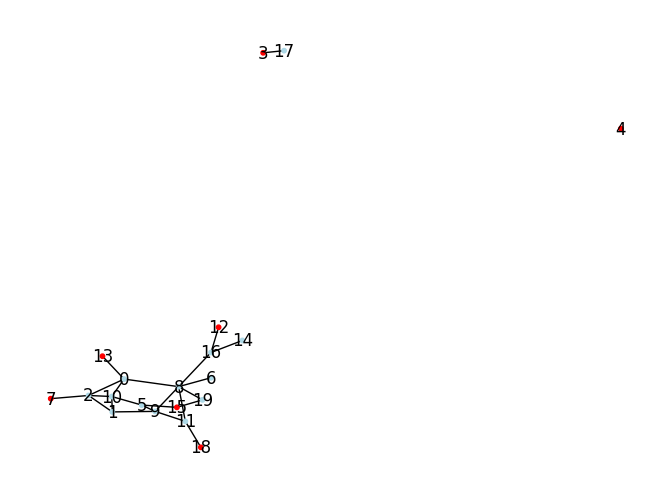

In [20]:
#the red nodes are part of the maximal independent set and the blue nodes are not part of the maximal independent set
nodes_color = ["red" if node in MIS else "lightblue" for node in big_graph.nodes]

nx.draw(big_graph, pos = pos_2, with_labels = True, node_color = nodes_color, node_size=10)
plt.show()

It's important to note here that the answer given by the BIG_QMIS isn't always the optimal maximal independent set. Observe it in your result obtained. Also, the results obtained is not the same for each run. That is because the Quantum_MIS isn't a determinist algorithm, it's a probabilistic approach. 

## **Our implementation of the Recupex's problem** (see our paper in french for more information)

In our method to solve the problem, we used three different functions. 

1. The `simplify_bins`function that takes the actual bins of Recupex placed in Sherbrooke and does an MIS on them to keep the maximal independent set of bins. This function returns the maximal independent set founded, and in case of a tie, the set with the most volume in the past three years is chosen.

The arguments of this function are: 

- radius_km (float): The distance in km of which two locations must be connected if they do not produce enough volume.

- pulse (Callable = Pulse_constructor(4000, "Rise_fall")): The pulse to be applied on the atoms in the QMIS algorithm.

- show_map (bool = False): Whether or not to show the maps of the original bins locations and their simplified distribution.

- save_map (bool = False): Whether or not to save the maps of the original bins locations and their simplified distribution.

- path (str = ""):The local path to the ReQpex repository.

- bin_image (bool = False): Whether or not to use Recupex bins as pings on the map.

- use_quantum (bool=True): Whether or not to use the QMIS method instead of the classic MIS solution.
    
- num_atoms (int=6): The maximum number of nodes per graph sent to the QMIS.


2. The `remove_possibles_new_locations`function looks for all the potential locations for new bins. It reduces the locations to keep only the important locations using the radius given by the user and the bins placed with the first function.

The arguments of this function are:

- radius_km (float): The distance of which if a possible location is within that range of an bin or an Estrie-Aide bin,
it must be removed form the possibilities.

- show_map (bool = False): Whether or not to show the maps of the simplified possible locations.

- save_map (bool = False): Whether or not to save the maps of the simplified possible locations.

- path (str = ""):The local path to the ReQpex repository.

- bin_image (bool = False): Whether or not to use Recupex' bins as pings on the map.

3. The `place_new_bins` function that does an MIS on all of the bins with the new possible locations. This function help us to find new positions of bins for Recupex.

The arguments of this function are:

- radius_km (float): The distance in km of which two locations must be connected if they do not produce enough volume.

- pulse (Callable = Pulse_constructor(4000, "Rise_fall")): The pulse to be applied on the atoms in the QMIS algorithm.

- show_map (bool = False): Whether or not to show the map of the new optimal distribution of the Recupex bins.

- save_map (bool = False): Whether or not to save the map of the new optimal distribution of the Recupex bins.

- path (str = ""):The local path to the ReQpex repository.

- bin_image (bool = False): Whether or not to use Recupex' bins as pings on the map.

- use_quantum (bool=True): Whether or not to use the QMIS method instead of the classic MIS solution.

- num_atoms (int=4): The maximum number of nodes per graph sent to the QMIS.

We use these 3 functions in the order I just showed them in the main file of our project to generate a map of all the bins in Sherbrooke. 

Here's a code cellule that generates a solution for our problem (the dataset folder must be downloaded before and the path to this folder must be specified).

Note that the solution map will be saved in a solution folder in the path you gave to the algorithm. The new bins added can be found under the file with name new_bins.csv in your dataset folder.

In [21]:
# defining the radius for the three functions of our solution
radius_simplify_bins = 1.5
radius_simplify_locations = 1.5
radius_new_distribution = 2.8

# this is the path to the dataset folder, insert your path instead of mine 
path = "/Users/ludo/library/cloudstorage/onedrive-personnel/documents/ludovic/école/université/automne_24/bsq201/ReQpex/"

#these are the parameters for the three functions that have been shown before
save_maps = False
show_maps = False
bin_images = True
save_maps_recap = True
show_maps_recap = True
show_estrie_aide = True

#these are parameters for the qaa mis algorithm which is used to find MIS of subgraphs
use_quantum = True
num_atoms = [10, 7]
pulse = Pulse_constructor(4000, "Rise_fall")

We can now run the three functions and show our final map obtained. The final map will be shown on your browser.Also, note that this cellule might take a few seconds to run given to the number of atoms used for the quantum MIS. The code will also not stop because of the map opened in your browser. The only way to stop it for this tutorial is by forcing it to stop.

In [22]:
from recupex_solver import simplify_bins, remove_possibles_new_locations, place_new_bins
from utils.generate_maps import recap_map_getter

#
simplify_bins(
        radius_simplify_bins,
        path=path,
        show_map=show_maps,
        save_map=save_maps,
        bin_image=bin_images,
        use_quantum=use_quantum,
        num_atoms=num_atoms[0],
        pulse=pulse,
    )
print("Bins simplified")
print("******************************************")

remove_possibles_new_locations(
        radius_simplify_locations,
        path=path,
        save_map=save_maps,
        show_map=show_maps,
        bin_image=bin_images,
    )
print("Possible locations simplified")
print("******************************************")

place_new_bins(
        radius_new_distribution,
        show_map=show_maps,
        save_map=save_maps,
        path=path,
        bin_image=bin_images,
        use_quantum=use_quantum,
        num_atoms=num_atoms[1],
        pulse=pulse,
    )
print("New distribution calculated")
print("******************************************")

if save_maps_recap or show_maps_recap:
    recap_map_getter(
            path=path,
            show_estrie_aide=show_estrie_aide,
            show=show_maps_recap,
            save=save_maps_recap,
        )

Partitioned the graph
Subgraphs created
MIS' done. Now combining

Sizes
OG size:  49
New size:  26
Bins removed:  23
Bins simplified
******************************************

Sizes
OG size:  2408
New size:  245
Locations removed:  2163
Possible locations simplified
******************************************
Partitioned the graph
Subgraphs created
MIS' done. Now combining

New number of bins:  54
New distribution calculated
******************************************
Color code
A blue pin is a bin that will stay
A green pin is a bin that will be added
A red pin is a bin that will be removed
A purple pin is an Estrie-Aide bin

Your map should have been opened in your browser automatically.
Press ctrl+c to return.
